In [182]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

# Building Functions we will use later

### Function for plotting

In [183]:
def plot(originalpd, adjustedpd, title, xlegend, ylegend):
    fig  = plt.figure(figsize=(11,7))
    plt.plot(originalpd, color='blue', label=xlegend)
    plt.plot(adjustedpd, color='red', label=ylegend)
    plt.legend(loc='best')
    plt.title(title)
    return plt.show(block=False)

# Function for dickey fuller test

In [184]:
def adftest(adjustedpd):
    adf_test = adfuller(adjustedpd)
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in adf_test[4].items():
        adf_output['Critical Value (%s)'%key] = value
    
    return print (adf_output)

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [185]:
import pandas as pd

In [186]:
data = pd.read_csv('zillow_data.csv')

In [187]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [188]:
len(data['RegionName'].unique())

14723

In [189]:
data_col_list = list(data.columns)

In [190]:
data_col_list = data_col_list[:7]

In [191]:
data_col_list

['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

In [192]:
data_1 = data[data_col_list]

In [193]:
data_1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
0,84654,60657,Chicago,IL,Chicago,Cook,1
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2
2,91982,77494,Katy,TX,Houston,Harris,3
3,84616,60614,Chicago,IL,Chicago,Cook,4
4,93144,79936,El Paso,TX,El Paso,El Paso,5


In [194]:
data_1.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
dtype: int64

In [195]:
data_1['Metro'].value_counts(dropna=False)

NaN                               1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
                                  ... 
Pampa                                1
Houghton                             1
Starkville                           1
Fredericksburg                       1
Deming                               1
Name: Metro, Length: 702, dtype: int64

In [196]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 7 columns):
RegionID      14723 non-null int64
RegionName    14723 non-null int64
City          14723 non-null object
State         14723 non-null object
Metro         13680 non-null object
CountyName    14723 non-null object
SizeRank      14723 non-null int64
dtypes: int64(3), object(4)
memory usage: 805.3+ KB


In [197]:
df[df['Col2'].isnull()]

NameError: name 'df' is not defined

In [198]:
data_1_null = data_1[data_1['Metro'].isnull()]

In [199]:
data_1_null.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
151,69340,27410,Greensboro,NC,NaN,Guilford,152
167,69336,27406,Greensboro,NC,NaN,Guilford,168
491,69270,27265,High Point,NC,NaN,Guilford,492
526,69337,27407,Greensboro,NC,NaN,Guilford,527
695,69335,27405,Greensboro,NC,NaN,Guilford,696


In [200]:
for col in data_1_null:
    print('Values for {}:\n{}\n\n'.format(col, data_1_null[col].value_counts(dropna=False)))

Values for RegionID:
94207    1
78557    1
94028    1
78548    1
86737    1
        ..
75130    1
66936    1
66934    1
66932    1
79367    1
Name: RegionID, Length: 1043, dtype: int64


Values for RegionName:
18431    1
27313    1
47042    1
76458    1
76457    1
        ..
15767    1
63660    1
65769    1
14812    1
73728    1
Name: RegionName, Length: 1043, dtype: int64


Values for City:
Greensboro      12
Carthage         4
High Point       4
Lexington        4
Homer            3
                ..
Monahans         1
Sherburn         1
Edon             1
Port Hadlock     1
Cisco            1
Name: City, Length: 941, dtype: int64


Values for State:
TX    116
TN     68
IN     65
KS     57
MS     55
NY     52
MO     50
MI     42
CA     42
NC     37
VA     36
MN     36
WI     30
MT     28
GA     28
FL     27
ID     23
OK     21
NH     21
LA     20
CO     20
OH     18
WA     18
MD     17
PA     15
UT     12
WY     11
ND     10
IL     10
OR      8
AL      8
KY      7
SC      7
AK      

In [201]:
data_1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
0,84654,60657,Chicago,IL,Chicago,Cook,1
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2
2,91982,77494,Katy,TX,Houston,Harris,3
3,84616,60614,Chicago,IL,Chicago,Cook,4
4,93144,79936,El Paso,TX,El Paso,El Paso,5


In [202]:
data_col_list2 = list(data.columns)

In [203]:
data_col_list2 = data_col_list2[7:]

In [204]:
data_2 = data[data_col_list2]

In [205]:
data_2.isna().sum()

1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
1996-08    1039
           ... 
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 265, dtype: int64

# Step 2: Data Preprocessing

In [206]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [207]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [208]:
xx = get_datetimes(data)

In [209]:
xx

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Step 3: EDA and Visualization

In [210]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

NameError: name 'matplotlib' is not defined

# Step 4: Reshape from Wide to Long Format

In [211]:
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [212]:
list(data.columns[:7])

['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

In [213]:
def melt_data(df):
    melted = pd.melt(df, id_vars=list(data.columns[:7]), var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [214]:
df = melt_data(data)

In [215]:
df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
value    265 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


In [217]:
inflation = pd.read_csv('CSUSHPINSA.csv')

In [218]:
inflation.head()

,DATE,CSUSHPINSA
0,1987-01-01,63.754
1,1987-02-01,64.155
2,1987-03-01,64.490
3,1987-04-01,64.995
4,1987-05-01,65.569


In [219]:
inflation.describe()

,CSUSHPINSA
count,398.000000
mean,127.945568
std,45.037013
min,63.754000
25%,80.465250
50%,134.081500
75%,167.021250
max,213.159000


In [220]:
inflation['DATE'] = pd.to_datetime(inflation['DATE'])

In [221]:
inflation.set_index('DATE', inplace=True)

In [222]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398 entries, 1987-01-01 to 2020-02-01
Data columns (total 1 columns):
CSUSHPINSA    398 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Filtering the dataframe down to the dates we need

In [223]:



inflation = inflation['1996-04' : '2018-04']

In [224]:
inflation.head()

,CSUSHPINSA
DATE,
1996-04-01,82.144
1996-05-01,82.622
1996-06-01,83.070
1996-07-01,83.443
1996-08-01,83.671


In [225]:
inflation.tail()

,CSUSHPINSA
DATE,
2017-12-01,195.970
2018-01-01,196.241
2018-02-01,197.032
2018-03-01,198.696
2018-04-01,200.729


We will need to calculate the real prices, adjusted for inflation. We take the latest date (2018-04-01) of 200.729 and use this to work out the historical prices in real terms.

In [226]:
inflation['pct_change'] = inflation['CSUSHPINSA'] / 200.729

In [227]:
inflation_merged = pd.concat([inflation,df], axis=1)

In [228]:
inflation_merged.head()

,CSUSHPINSA,pct_change,value
1996-04-01,82.144,0.409228,118299.123063
1996-05-01,82.622,0.411610,118419.044139
1996-06-01,83.070,0.413842,118537.423268
1996-07-01,83.443,0.415700,118653.069278
1996-08-01,83.671,0.416836,118780.254312


We will now calculate the inflation adjusted prices

In [229]:
inflation_merged['infl_adj_value'] = inflation_merged['value'] / inflation_merged['pct_change']

In [230]:
inflation_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value
1996-04-01,82.144,0.409228,118299.123063,289078.504497
1996-05-01,82.622,0.411610,118419.044139,287697.420917
1996-06-01,83.070,0.413842,118537.423268,286431.906045
1996-07-01,83.443,0.415700,118653.069278,285429.717809
1996-08-01,83.671,0.416836,118780.254312,284957.054030


In [231]:
state_melted_df = pd.DataFrame()
for state in list(data['State'].unique()):
    coumn_name = "melted_" + state
    state_melted_df[coumn_name] = melt_data(data.loc[(data['State']== state)])['value']


In [232]:
state_melted_df_merged = pd.concat([inflation_merged, state_melted_df], axis=1)

In [233]:
state_melt_list = list(state_melted_df_merged)
state_melt_list = state_melt_list[4:55]

In [234]:
state_melted_df_merged[state_melt_list] = state_melted_df_merged[state_melt_list].apply(lambda x: x/state_melted_df_merged['pct_change'])

In [235]:
state_melted_df_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value,melted_IL,melted_TX,melted_NY,melted_CA,melted_FL,melted_TN,...,melted_ME,melted_SD,melted_WV,melted_IA,melted_RI,melted_NE,melted_WY,melted_AK,melted_NH,melted_VT
1996-04-01,82.144,0.409228,118299.123063,289078.504497,311866.617884,267294.864732,317493.909413,489264.620651,255429.557568,161492.884435,...,240008.246715,132737.622711,162407.283409,191571.818532,306152.877275,218627.494087,338961.109911,313717.607538,261792.266370,202393.107531
1996-05-01,82.622,0.411610,118419.044139,287697.420917,310694.109021,265802.507059,315470.125780,486200.495416,254109.954264,161174.177668,...,238256.861510,132747.120137,161743.036661,191008.494817,304089.303419,219323.592419,337121.564020,312995.899440,260251.533875,200569.261289
1996-06-01,83.070,0.413842,118537.423268,286431.906045,309401.078233,264476.531572,313588.963934,483363.606049,252904.411262,160919.047064,...,236604.767439,132804.452149,161192.934172,190471.450885,302154.456299,219953.058900,335253.111934,312326.232566,258864.095644,198883.486894
1996-07-01,83.443,0.415700,118653.069278,285429.717809,308122.889620,263462.986998,311990.097684,481033.632305,251929.554194,160796.593836,...,235165.972168,133004.642810,160809.164360,190058.877374,300453.146236,220636.567768,333513.932964,311857.965104,257710.643661,197347.954142
1996-08-01,83.671,0.416836,118780.254312,284957.054030,307136.940648,262966.920484,310969.935499,479706.478631,251458.812265,160930.829254,...,234169.974019,133529.850725,160774.802301,189899.207934,299349.793552,221478.185751,332345.226741,311942.072095,257052.682592,196195.438458


In [236]:
state_melted_df_merged.drop(columns=['CSUSHPINSA','pct_change','value'], inplace=True)

In [237]:
temp_state_year = state_melted_df_merged.resample('Y')
state_year = temp_state_year.sum()

In [238]:
state_year_pct = state_year.pct_change()

In [239]:
state_year_pct_07 = state_year_pct["2007":"2014"]
state_year_pct_07

,infl_adj_value,melted_IL,melted_TX,melted_NY,melted_CA,melted_FL,melted_TN,melted_NC,melted_GA,melted_DC,...,melted_ME,melted_SD,melted_WV,melted_IA,melted_RI,melted_NE,melted_WY,melted_AK,melted_NH,melted_VT
2007-12-31,0.007879,0.024806,0.062560,0.015375,-0.029708,-0.043409,0.074493,0.066996,0.052176,0.041058,...,-0.002792,0.038843,0.006224,0.045727,-0.025485,0.040244,0.127380,0.078880,-0.002901,0.033715
2008-12-31,0.017075,0.031243,0.087357,0.066711,-0.059455,-0.092686,0.074750,0.082332,0.056587,0.053338,...,0.029226,0.113488,0.070837,0.098684,-0.006932,0.069974,0.129190,0.115363,0.033321,0.088102
2009-12-31,0.014076,0.003075,0.073574,0.047204,-0.028423,-0.108041,0.069371,0.051561,0.019593,0.055822,...,0.013064,0.102543,0.061056,0.100934,-0.006036,0.120449,0.078609,0.110220,0.023145,0.078390
2010-12-31,-0.014401,-0.031751,0.007244,0.011133,0.000030,-0.059500,0.010961,-0.011105,-0.033283,0.016240,...,0.033255,0.011651,0.017207,0.032475,0.007709,0.017198,-0.035802,0.036886,0.007621,0.041274
2011-12-31,-0.013927,-0.040910,0.017097,0.010522,-0.019957,-0.028623,0.006490,-0.013930,-0.061039,0.026418,...,0.012222,0.031844,0.028886,0.026283,-0.026068,-0.008341,0.025103,0.052376,-0.004109,0.038437
2012-12-31,-0.014831,-0.038869,-0.007143,-0.026813,0.011048,0.001513,-0.014616,-0.027175,-0.040018,0.015389,...,-0.004104,0.012468,0.001541,0.002194,-0.033302,-0.003593,0.000692,-0.004357,-0.017619,-0.020399
2013-12-31,-0.030808,-0.044609,-0.052752,-0.065249,0.064603,-0.011609,-0.062747,-0.068100,-0.027143,-0.023702,...,-0.059368,-0.055100,-0.057824,-0.059473,-0.074677,-0.054693,-0.064363,-0.070165,-0.066060,-0.068868
2014-12-31,-0.005225,-0.011645,-0.009325,0.004509,0.038931,0.038608,-0.024124,-0.038816,0.010357,0.007893,...,-0.032666,-0.030361,-0.052029,-0.034235,-0.034384,-0.033958,-0.037134,-0.050727,-0.029679,-0.048469


In [240]:
state_year_pct_07 = state_year_pct_07.sum()

In [241]:
state_year_pct_07.head()

infl_adj_value   -0.040162
melted_IL        -0.108661
melted_TX         0.178612
melted_NY         0.063393
melted_CA        -0.022929
dtype: float64

In [242]:
positive_states = state_year_pct_07[state_year_pct_07 >0]

In [243]:
positive_states.sort_values(ascending=False)

melted_ND    0.368846
melted_AK    0.268476
melted_UT    0.229893
melted_SD    0.225376
melted_WY    0.223675
melted_IA    0.212588
melted_OK    0.208769
melted_DC    0.192457
melted_TX    0.178612
melted_NE    0.147280
melted_CO    0.144193
melted_VT    0.142182
melted_LA    0.137603
melted_TN    0.134578
melted_MT    0.111540
melted_KY    0.097446
melted_AR    0.094722
melted_WV    0.075898
melted_NY    0.063393
melted_NC    0.041762
melted_IN    0.038573
melted_MA    0.033023
melted_PA    0.031126
melted_WI    0.029723
melted_ID    0.027905
melted_AL    0.021674
melted_WA    0.012928
melted_MO    0.005950
melted_OH    0.002577
dtype: float64

In [244]:
positive_states_list=[ "TX","NY","TN","NC", "DC", "MO", "OK", "WA","OH", "MA",   "PA",    "CO",    "IN",    "KY",    "AR",    "ND",    "AL",    "LA",    "ID",    "MT",    "WI",    "UT",   "SD",    "WV",   "IA",    "NE",   "WY",    "AK",    "VT"] 

In [245]:
data2 = data[data['State'].isin(positive_states_list)]

In [246]:
city_melted_df = pd.DataFrame()
for city in list(data['City'].unique()):
    coumn_name = "melted_" + city
    city_melted_df[coumn_name] = melt_data(data.loc[(data['City']== city)])['value']

In [247]:
city_melted_df_merged = pd.concat([inflation_merged, city_melted_df], axis=1)

In [248]:
city_melt_list = list(city_melted_df_merged)
city_melt_list = city_melt_list[4:7558]

In [249]:
city_melted_df_merged[city_melt_list] = city_melted_df_merged[city_melt_list].apply(lambda x: x/city_melted_df_merged['pct_change'])

In [250]:
city_melted_df_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value,melted_Chicago,melted_McKinney,melted_Katy,melted_El Paso,melted_Houston,melted_New York,...,melted_Barbeau,melted_Shandaken,melted_Coolin,melted_Waterville Valley,melted_East Spencer,melted_Glenbrook,melted_Green Valley Lake,melted_Pine Valley,melted_Esopus,melted_Mount Crested Butte
1996-04-01,82.144,0.409228,118299.123063,289078.504497,431928.761900,449708.158437,342351.637369,204572.005056,398140.127717,524937.297588,...,130245.126850,173252.898568,NaN,NaN,NaN,1.374294e+06,205753.089696,332088.419118,191335.711677,466976.430415
1996-05-01,82.622,0.411610,118419.044139,287697.420917,430553.525453,446377.578208,342071.641936,203091.540254,396373.481104,522907.168828,...,130220.454600,171035.820968,NaN,NaN,NaN,1.367315e+06,204562.729055,331138.954516,190228.761105,467433.124349
1996-06-01,83.070,0.413842,118537.423268,286431.906045,428908.119658,442439.868785,340710.111954,201835.166794,394814.630474,521209.332884,...,130001.446972,169146.864091,NaN,NaN,NaN,1.359699e+06,203701.152040,330078.023354,188961.211027,468053.536776
1996-07-01,83.443,0.415700,118653.069278,285429.717809,427135.184977,438377.272709,338465.423103,200772.567767,393715.493657,520054.500424,...,130141.999928,167669.083087,NaN,NaN,NaN,1.352899e+06,202790.583991,329324.210539,188116.532244,469088.539482
1996-08-01,83.671,0.416836,118780.254312,284957.054030,425671.380944,434863.653277,336183.670168,200118.847430,393373.501697,519917.623570,...,130027.271098,166252.580942,NaN,NaN,NaN,1.348973e+06,202237.988072,328906.621171,187364.019792,470929.027979


In [251]:
city_melted_df_merged.drop(columns=['CSUSHPINSA','pct_change','value'], inplace=True)

In [252]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [253]:
data2_list = list(data2['State'].unique())

In [254]:
data2['State'].value_counts()

NY    1015
TX     989
PA     831
OH     588
NC     428
IN     428
MA     417
TN     404
WA     341
WI     332
MO     319
CO     249
OK     221
LA     193
AL     183
IA     158
KY     139
UT     121
ID     110
AR     105
NE      83
WV      72
MT      71
WY      31
ND      31
AK      28
SD      19
DC      18
VT      16
Name: State, dtype: int64

In [255]:
zip_melted_df = pd.DataFrame()
for zipcode in list(data2['RegionName'].unique()):
    coumn_name = "melted_" + str(zipcode)
    zip_melted_df[coumn_name] = melt_data(data2.loc[(data2['RegionName']== zipcode)])['value']

In [256]:
zip_melted_df_merged = pd.concat([inflation_merged, zip_melted_df], axis=1)

In [257]:
zip_melt_list = list(zip_melted_df_merged)
zip_melt_list = zip_melt_list[4:7944]

In [258]:
zip_melted_df_merged[zip_melt_list] = zip_melted_df_merged[zip_melt_list].apply(lambda x: x/zip_melted_df_merged['pct_change'])

In [259]:
zip_melted_df_merged.drop(columns=['CSUSHPINSA','pct_change','value'], inplace=True)

In [260]:
zip_melted_df_merged.head()

,infl_adj_value,melted_75070,melted_77494,melted_79936,melted_77084,melted_10467,melted_77449,melted_11226,melted_11375,melted_11235,...,melted_1270,melted_12480,melted_83821,melted_28039,melted_84781,melted_12429,melted_12720,melted_1338,melted_40404,melted_81225
1996-04-01,289078.504497,575962.033746,514138.361901,188892.088284,232144.222341,373630.016800,233121.671698,395866.989677,616770.544410,465510.256379,...,265377.500487,173252.898568,NaN,NaN,332088.419118,191335.711677,152726.462067,231166.772984,139530.895744,466976.430415
1996-05-01,287697.420917,575545.255501,515536.948997,187799.275011,231287.076081,370982.526446,232258.870519,394305.592941,611744.598291,464031.843819,...,260926.806420,171035.820968,NaN,NaN,331138.954516,190228.761105,152085.829440,229100.538597,139209.553146,467433.124349
1996-06-01,286431.906045,571958.039003,512756.636572,186786.465631,230523.011918,368740.163717,231489.565427,392904.001445,607478.880462,462737.492476,...,256619.956663,169146.864091,NaN,NaN,330078.023354,188961.211027,151507.262550,227140.074636,138942.066932,468053.536776
1996-07-01,285429.717809,566274.062534,506856.180866,185951.508215,230214.221684,366610.735472,231176.454586,392109.907362,604282.262143,461871.792721,...,252586.136644,167669.083087,NaN,NaN,329324.210539,188116.532244,150830.007310,225403.057177,138802.096042,469088.539482
1996-08-01,284957.054030,559693.032233,499717.353683,185684.700792,230066.702920,365371.833730,231266.216491,392001.035006,602395.715361,461812.724839,...,248779.114628,166252.580942,NaN,NaN,328906.621171,187364.019792,150419.001805,224069.135065,139143.574237,470929.027979


In [261]:
temp_zip = zip_melted_df_merged.resample('Y')
zip_year = temp_zip.mean()

In [262]:
zip_year_pct = zip_year.pct_change()

In [263]:
zip_year_df = pd.DataFrame(zip_year_pct.sum().sort_values(ascending=False))

In [264]:
zip_year_df.head(5)

,0
melted_11222,1.693251
melted_11211,1.692034
melted_11216,1.608895
melted_11930,1.509036
melted_11215,1.492445


In [265]:
zip_melted_df_merged = zip_melted_df_merged[['infl_adj_value',
                                            'melted_11222',
                                            'melted_11211',
                                            'melted_11216',
                                            'melted_11930',
                                            'melted_11215']]

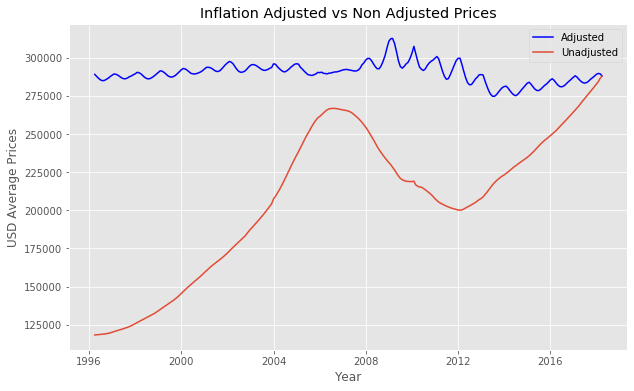

In [266]:
plt.figure(figsize=(10,6))
plt.plot(inflation_merged['infl_adj_value'], color='blue', label='Adjusted')
plt.plot(df, label='Unadjusted')
plt.xlabel('Year')
plt.ylabel('USD Average Prices')
plt.legend()
plt.title('Inflation Adjusted vs Non Adjusted Prices')
plt.show()

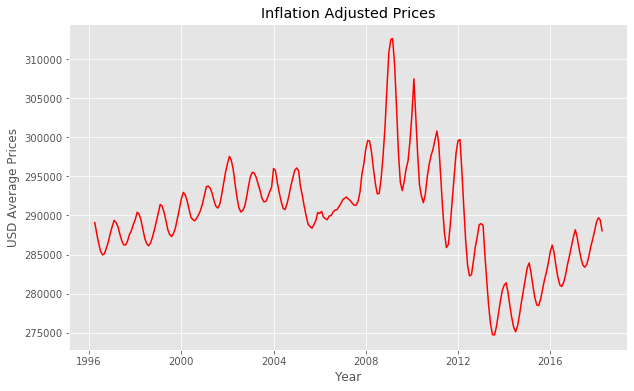

In [267]:
plt.figure(figsize=(10,6))
plt.plot(inflation_merged['infl_adj_value'], color='red')
plt.xlabel('Year')
plt.ylabel('USD Average Prices')
plt.title('Inflation Adjusted Prices')
plt.show()

It looks like there is some seasonality here, as well as clear up and downtrends.

In [268]:
adftest(inflation_merged['infl_adj_value'])

Test Statistic                  -1.704683
p-value                          0.428701
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [269]:
to_drop= list(data.columns[7:])

In [270]:
data.drop(columns=to_drop, axis=1, inplace=True)

In [271]:
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'],
      dtype='object')

# Checking for Stationarity

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
value    265 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


### Unadjusted Data

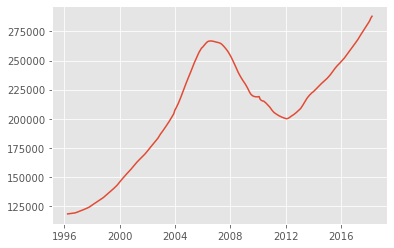

In [273]:
plt.plot(df)

In [274]:
df_roll_mean = df.rolling(window=12).mean()
df_roll_std = df.rolling(window=12).std()

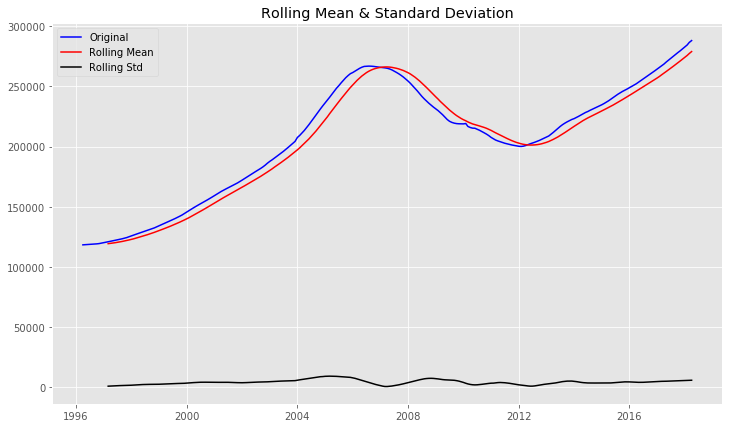

In [275]:
fig = plt.figure(figsize=(12,7))
plt.plot(df, color='blue', label='Original')
plt.plot(df_roll_mean, color='red', label='Rolling Mean')
plt.plot(df_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [276]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['value'])

In [277]:
adftest(df['value'])

Test Statistic                  -1.885145
p-value                          0.339082
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


HO : Non Stationary 

Ha : Stationary

Test Statistic is higher than critical value at all confidence levels. We fail to reject the null hypothesis. THe time series is non stationary

Data will need to be converted to stationary.

### Adjusted Data

In [278]:
infladj_roll_mean = inflation_merged['infl_adj_value'].rolling(window=12).mean()
infladj_roll_std = inflation_merged['infl_adj_value'].rolling(window=12).std()

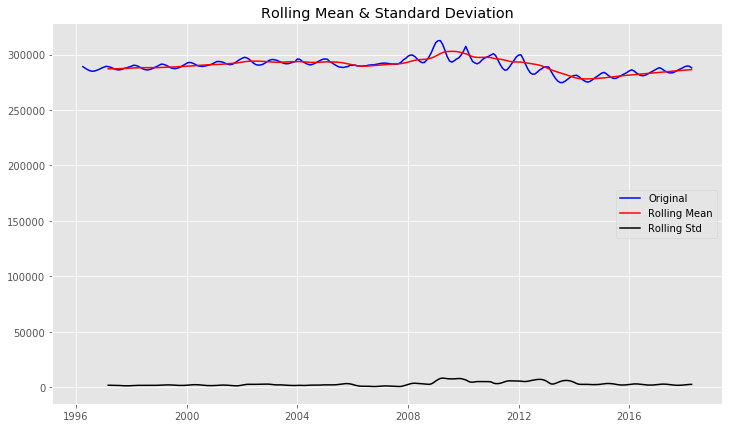

In [279]:
fig = plt.figure(figsize=(12,7))
plt.plot(inflation_merged['infl_adj_value'], color='blue', label='Original')
plt.plot(infladj_roll_mean, color='red', label='Rolling Mean')
plt.plot(infladj_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [280]:
adftest(inflation_merged['infl_adj_value'])

Test Statistic                  -1.704683
p-value                          0.428701
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [281]:
zip_11211_mean = zip_melted_df_merged['melted_11211'].rolling(window=12).mean()
zip_11211_roll_std = zip_melted_df_merged['melted_11211'].rolling(window=12).std()

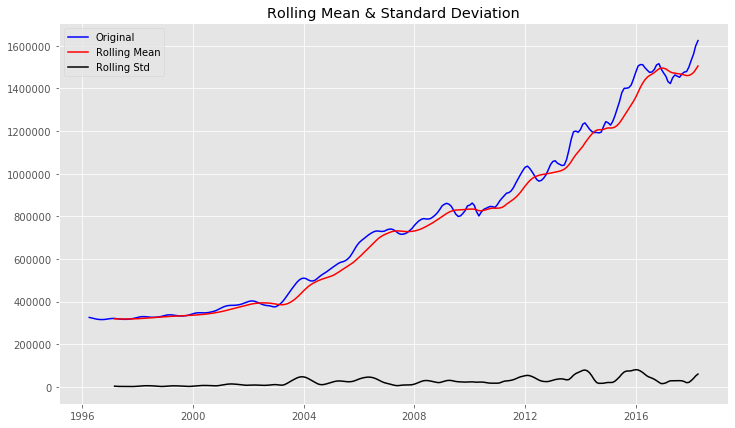

In [282]:
fig = plt.figure(figsize=(12,7))
plt.plot(zip_melted_df_merged['melted_11211'], color='blue', label='Original')
plt.plot(zip_11211_mean, color='red', label='Rolling Mean')
plt.plot(zip_11211_roll_std , color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [283]:
adftest(zip_melted_df_merged['melted_11211'])

Test Statistic                   2.694889
p-value                          0.999087
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [284]:
zip_11215_mean = zip_melted_df_merged['melted_11215'].rolling(window=12).mean()
zip_11215_roll_std = zip_melted_df_merged['melted_11215'].rolling(window=12).std()

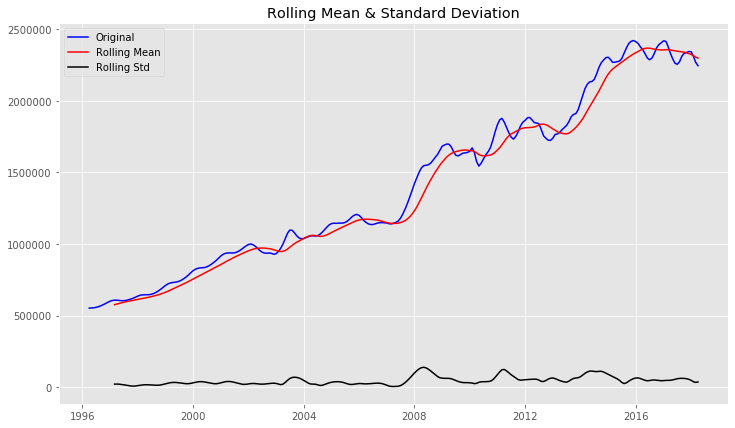

In [285]:
fig = plt.figure(figsize=(12,7))
plt.plot(zip_melted_df_merged['melted_11215'], color='blue', label='Original')
plt.plot(zip_11215_mean, color='red', label='Rolling Mean')
plt.plot(zip_11215_roll_std , color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [286]:
adftest(zip_melted_df_merged['melted_11215'])

Test Statistic                  -0.541131
p-value                          0.883737
#Lags Used                       8.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


In [287]:
zip_11216_mean = zip_melted_df_merged['melted_11216'].rolling(window=12).mean()
zip_11216_roll_std = zip_melted_df_merged['melted_11216'].rolling(window=12).std()

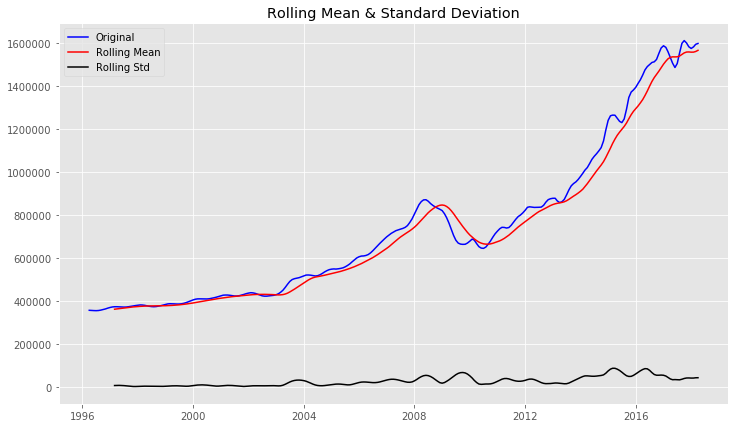

In [288]:
fig = plt.figure(figsize=(12,7))
plt.plot(zip_melted_df_merged['melted_11216'], color='blue', label='Original')
plt.plot(zip_11216_mean, color='red', label='Rolling Mean')
plt.plot(zip_11216_roll_std , color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [289]:
adftest(zip_melted_df_merged['melted_11216'])

Test Statistic                   1.223127
p-value                          0.996142
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [290]:
zip_11222_mean = zip_melted_df_merged['melted_11222'].rolling(window=12).mean()
zip_11222_roll_std = zip_melted_df_merged['melted_11222'].rolling(window=12).std()

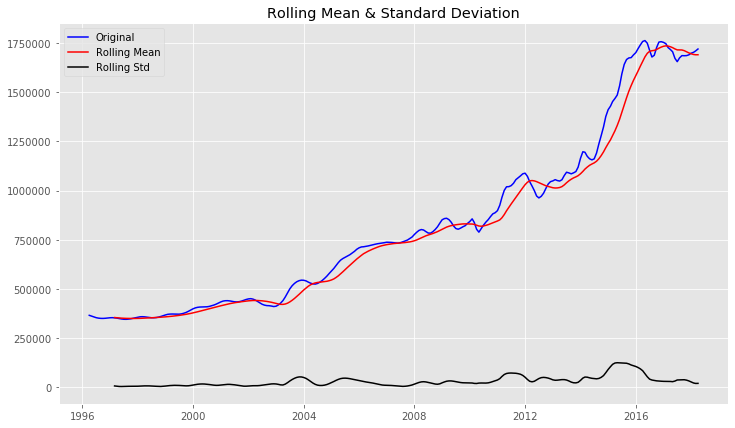

In [291]:
fig = plt.figure(figsize=(12,7))
plt.plot(zip_melted_df_merged['melted_11222'], color='blue', label='Original')
plt.plot(zip_11222_mean, color='red', label='Rolling Mean')
plt.plot(zip_11222_roll_std , color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [292]:
adftest(zip_melted_df_merged['melted_11222'])

Test Statistic                   0.851604
p-value                          0.992425
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [293]:
zip_11930_mean = zip_melted_df_merged['melted_11930'].rolling(window=12).mean()
zip_11930_roll_std = zip_melted_df_merged['melted_11930'].rolling(window=12).std()

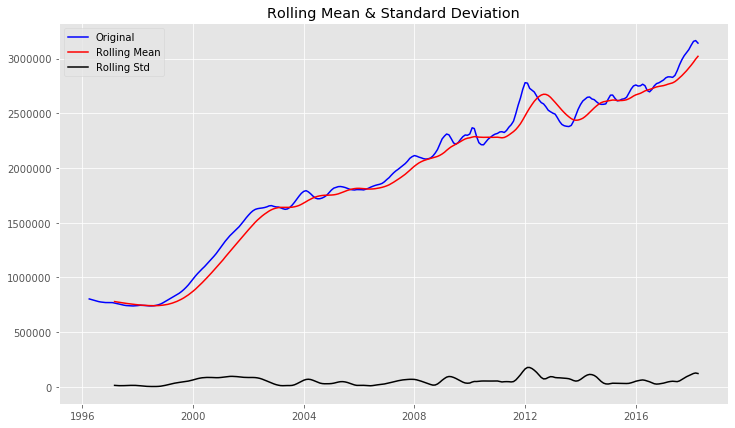

In [294]:
fig = plt.figure(figsize=(12,7))
plt.plot(zip_melted_df_merged['melted_11930'], color='blue', label='Original')
plt.plot(zip_11930_mean, color='red', label='Rolling Mean')
plt.plot(zip_11930_roll_std , color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [295]:
adftest(zip_melted_df_merged['melted_11930'])

Test Statistic                  -0.834493
p-value                          0.808780
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


# Removing Trends

In [304]:
import numpy as np

### Taking the log of the data

In [305]:
inflation_merged.head()

,CSUSHPINSA,pct_change,value,infl_adj_value
1996-04-01,82.144,0.409228,118299.123063,289078.504497
1996-05-01,82.622,0.411610,118419.044139,287697.420917
1996-06-01,83.070,0.413842,118537.423268,286431.906045
1996-07-01,83.443,0.415700,118653.069278,285429.717809
1996-08-01,83.671,0.416836,118780.254312,284957.054030


ConversionError: Failed to convert value(s) to axis units: array(['Chicago', 'McKinney', 'Katy', ..., 'Berea', 'Mount Crested Butte',
       'Mesquite'], dtype=object)

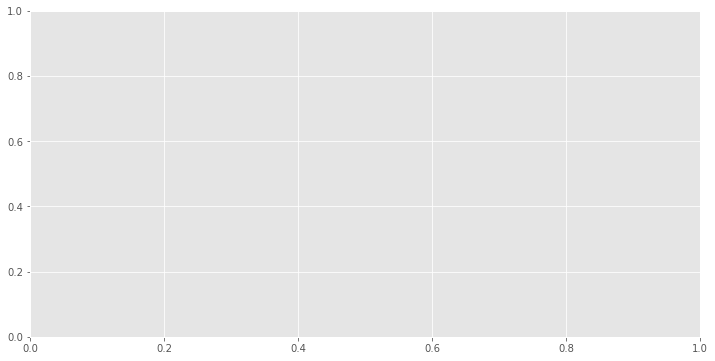

In [306]:
data_log = pd.Series(np.log(inflation_merged['infl_adj_value']))
fig = plt.figure(figsize=(12,6))
plt.plot(data, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('log(Average Price)', fontsize=14)
plt.show()

In [ ]:
adftest(data_log)

### Calculating the Rolling Mean

ConversionError: Failed to convert value(s) to axis units: array(['Chicago', 'McKinney', 'Katy', ..., 'Berea', 'Mount Crested Butte',
       'Mesquite'], dtype=object)

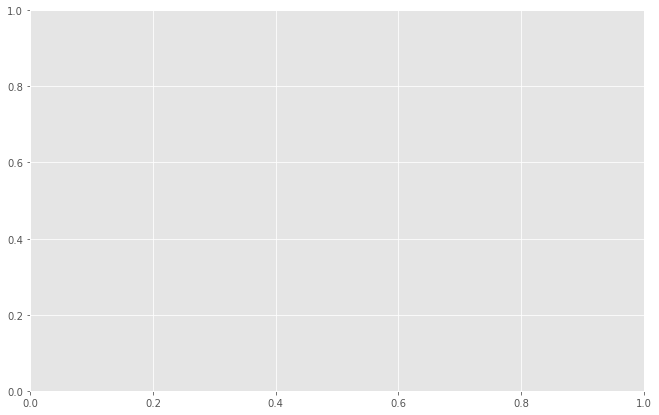

In [302]:
roll_mean = data_log.rolling(window=12).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(data, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show(block=False)

In [ ]:
data_minus_roll_mean = data - roll_mean
data_minus_roll_mean.head(15)

In [ ]:
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [ ]:
adftest(data_minus_roll_mean)

Eyeballing the graph, it looks like we have improved it slightly, but still does not look stationary. Dickey Fuller test confims this.


### Exponentially Weighted Rolling Mean

In [307]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank
0,84654,60657,Chicago,IL,Chicago,Cook,1
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2
2,91982,77494,Katy,TX,Houston,Harris,3
3,84616,60614,Chicago,IL,Chicago,Cook,4
4,93144,79936,El Paso,TX,El Paso,El Paso,5


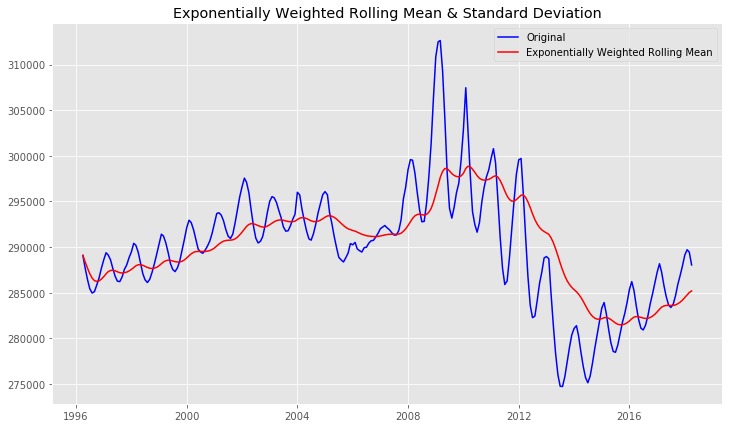

In [308]:
exp_roll_mean = inflation_merged['infl_adj_value'].ewm(halflife=12).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(inflation_merged['infl_adj_value'], color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [309]:
data_minus_exp_roll_mean = inflation_merged['infl_adj_value'] - exp_roll_mean
data_minus_exp_roll_mean.head(15)

1996-04-01       0.000000
1996-05-01    -670.603704
1996-06-01   -1253.129654
1996-07-01   -1641.737719
1996-08-01   -1641.314349
1996-09-01   -1195.446389
1996-10-01    -399.108609
1996-11-01     331.278510
1996-12-01    1187.047097
1997-01-01    1831.959882
1997-02-01    2309.961243
1997-03-01    1828.566674
1997-04-01    1159.234292
1997-05-01     197.620795
1997-06-01    -602.557535
Name: infl_adj_value, dtype: float64

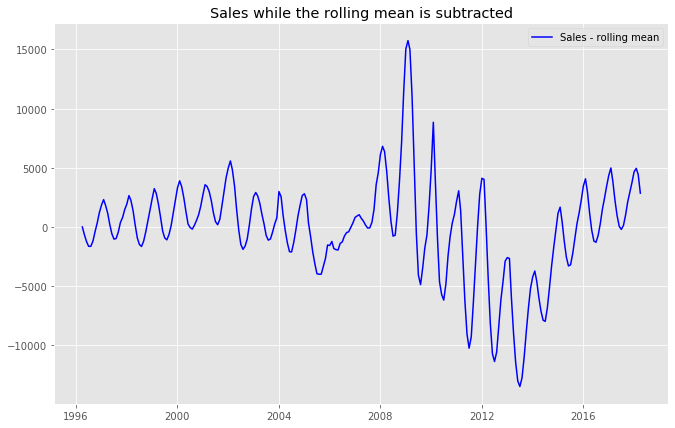

In [310]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [311]:
data_diff = data_minus_exp_roll_mean.diff(periods=1)
data_diff.head(10)

1996-04-01           NaN
1996-05-01   -670.603704
1996-06-01   -582.525950
1996-07-01   -388.608065
1996-08-01      0.423370
1996-09-01    445.867959
1996-10-01    796.337781
1996-11-01    730.387118
1996-12-01    855.768587
1997-01-01    644.912785
Name: infl_adj_value, dtype: float64

In [312]:
data_diff.dropna(inplace=True)

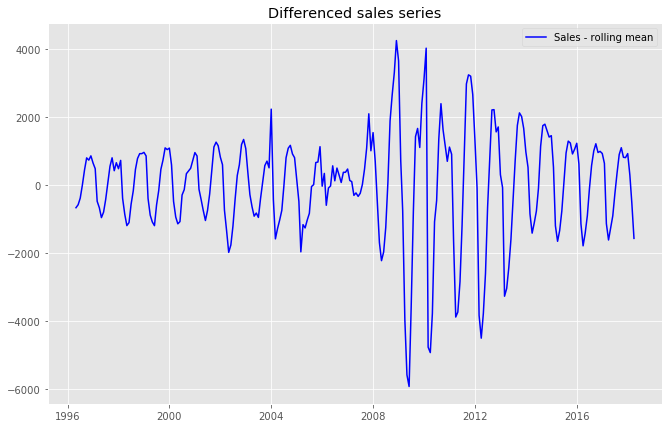

In [313]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [314]:
adftest(data_diff)

Test Statistic                  -4.715459
p-value                          0.000079
#Lags Used                      13.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


Looks like it is stationary here

Will apply this to our 5 zipcodes

In [315]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

In [316]:
exp_roll_mean_11222 = zip_melted_df_merged['melted_11222'].ewm(halflife=12).mean()
exp_roll_mean_11211 = zip_melted_df_merged['melted_11211'].ewm(halflife=12).mean()
exp_roll_mean_11216 = zip_melted_df_merged['melted_11216'].ewm(halflife=12).mean()
exp_roll_mean_11930 = zip_melted_df_merged['melted_11930'].ewm(halflife=12).mean()
exp_roll_mean_11215 = zip_melted_df_merged['melted_11215'].ewm(halflife=12).mean()

In [317]:
data_minus_exp_roll_mean_11222 =  zip_melted_df_merged['melted_11222'] - exp_roll_mean_11222
data_minus_exp_roll_mean_11211 =  zip_melted_df_merged['melted_11211'] - exp_roll_mean_11211
data_minus_exp_roll_mean_11216 =  zip_melted_df_merged['melted_11216'] - exp_roll_mean_11216
data_minus_exp_roll_mean_11930 =  zip_melted_df_merged['melted_11930'] - exp_roll_mean_11930
data_minus_exp_roll_mean_11215 =  zip_melted_df_merged['melted_11215'] - exp_roll_mean_11215

In [318]:
data_diff_11222 = data_minus_exp_roll_mean_11222.diff(periods=1)
data_diff_11211 = data_minus_exp_roll_mean_11211.diff(periods=1)
data_diff_11216 = data_minus_exp_roll_mean_11216.diff(periods=1)
data_diff_11930 = data_minus_exp_roll_mean_11930.diff(periods=1)
data_diff_11215 = data_minus_exp_roll_mean_11215.diff(periods=1)

In [319]:
data_diff_11222.dropna(inplace=True)
data_diff_11211.dropna(inplace=True)
data_diff_11216.dropna(inplace=True)
data_diff_11930.dropna(inplace=True)
data_diff_11215.dropna(inplace=True)

In [320]:
adftest(data_diff_11222)

Test Statistic                  -4.190603
p-value                          0.000683
#Lags Used                      13.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [321]:
adftest(data_diff_11211)

Test Statistic                -6.682710e+00
p-value                        4.301893e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


In [322]:
adftest(data_diff_11216)

Test Statistic                  -4.227521
p-value                          0.000592
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [323]:
adftest(data_diff_11930)

Test Statistic                -5.796238e+00
p-value                        4.744765e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


In [324]:
adftest(data_diff_11215)

Test Statistic                  -5.282077
p-value                          0.000006
#Lags Used                       7.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


In [325]:
data_diff2 = data.diff(periods=3)
data_diff2.head(10)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [326]:
data_diff2.dropna(inplace=True)

NameError: name 'data_diff2' is not defined

In [327]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff2, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

NameError: name 'data_diff2' is not defined

<Figure size 792x504 with 0 Axes>

In [ ]:
adftest(data_diff2)

In [328]:
data_diff3 = data.diff(periods=6)
data_diff3.head(10)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [329]:
data_diff3.dropna(inplace=True)

NameError: name 'data_diff3' is not defined

In [330]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff3, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

NameError: name 'data_diff3' is not defined

<Figure size 792x504 with 0 Axes>

In [ ]:
data_diff4 = data.diff(periods=12)
data_diff4.head(10)

In [331]:
data_diff4.dropna(inplace=True)

NameError: name 'data_diff4' is not defined

In [332]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff4, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

NameError: name 'data_diff4' is not defined

<Figure size 792x504 with 0 Axes>

In [ ]:
adftest(data_diff4)

6 month lag gives best results it seems, will try stationarity test on it now.

In [333]:
data_diff4

NameError: name 'data_diff4' is not defined

In [334]:
dftest_diff4 = adfuller(data_diff4)

NameError: name 'data_diff4' is not defined

In [335]:
dfoutput_diff4 = pd.Series(dftest_diff4[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_diff4[4].items():
    dfoutput_diff4['Critical Value (%s)'%key] = value
print(dftest_diff4)



print ('Results of Dickey-Fuller test: \n')

print(dfoutput_diff4)

NameError: name 'dftest_diff4' is not defined

# sqrt

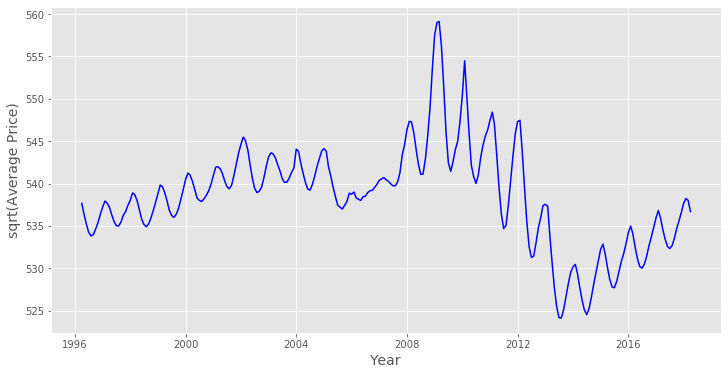

In [336]:
data2 = pd.Series(np.sqrt(inflation_merged['infl_adj_value']))
fig = plt.figure(figsize=(12,6))
plt.plot(data2, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('sqrt(Average Price)', fontsize=14)
plt.show()

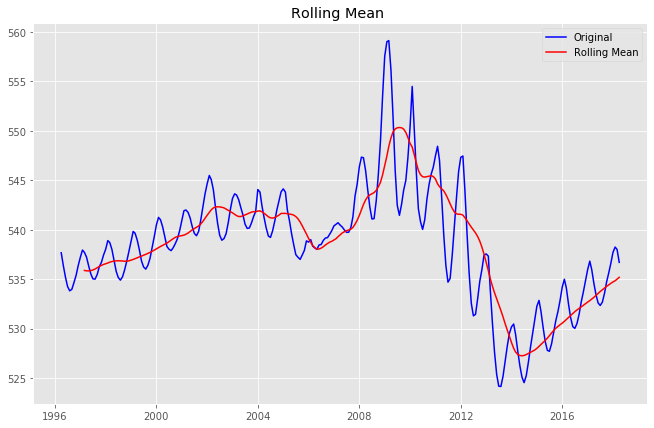

In [337]:
roll_mean = data2.rolling(window=12).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(data2, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean ')
plt.show(block=False)

In [338]:
data_diff5 = data2.diff(periods=6)
data_diff5.head(10)

1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01         NaN
1996-08-01         NaN
1996-09-01         NaN
1996-10-01   -3.024961
1996-11-01   -1.001123
1996-12-01    1.156355
1997-01-01    2.944490
Name: infl_adj_value, dtype: float64

In [339]:
data_diff5.dropna(inplace=True)

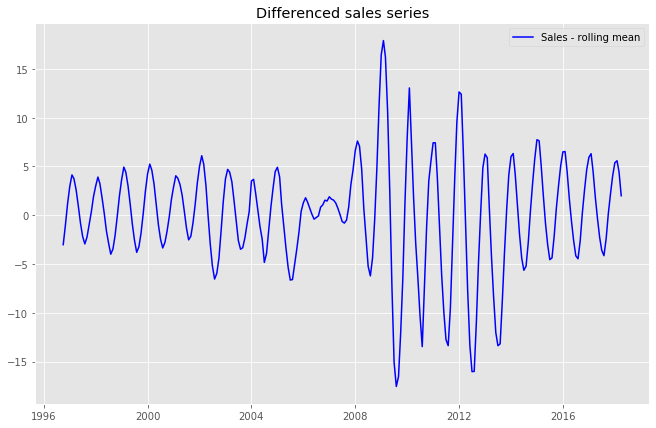

In [340]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff5, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [341]:
adftest(data_diff5)

Test Statistic                  -3.042938
p-value                          0.031074
#Lags Used                      13.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


290098.24788696 1.0000133102301445 0.9999622460834626


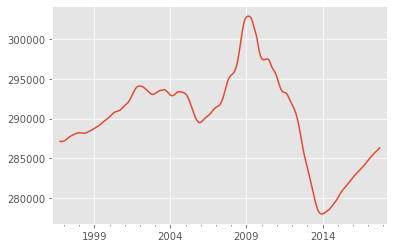

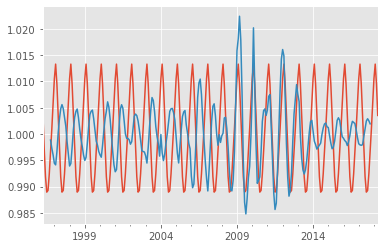

In [342]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(inflation_merged['infl_adj_value'],model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print(trend.mean(),seasonal.mean(),residual.mean())

trend.plot()
plt.show()
seasonal.plot()
residual.plot()
plt.show()

8.615026299696048 8.268133652481166e-14 1.3864420043214576


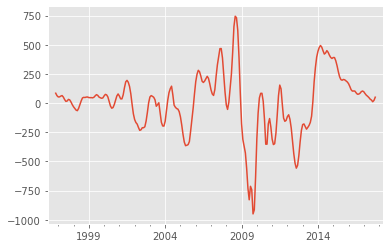

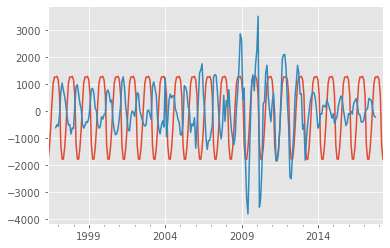

In [343]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_diff,model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

print(trend.mean(),seasonal.mean(),residual.mean())

trend.plot()
plt.show()
seasonal.plot()
residual.plot()
plt.show()

# Models

In [344]:
data_diff

1996-05-01    -670.603704
1996-06-01    -582.525950
1996-07-01    -388.608065
1996-08-01       0.423370
1996-09-01     445.867959
                 ...     
2017-12-01     804.773973
2018-01-01     922.652364
2018-02-01     288.680597
2018-03-01    -524.710451
2018-04-01   -1572.585884
Name: infl_adj_value, Length: 264, dtype: float64

# ARMA MODEL

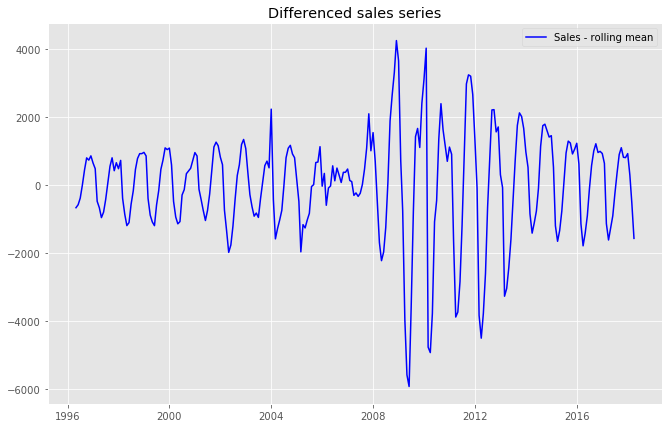

In [345]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

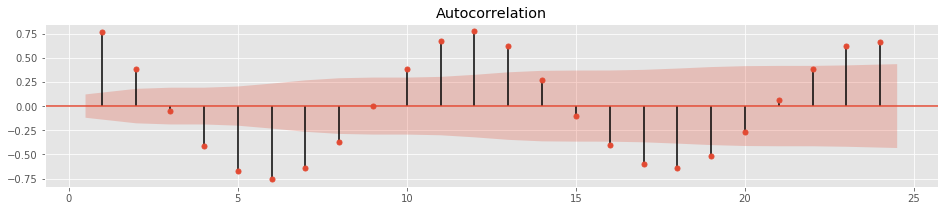

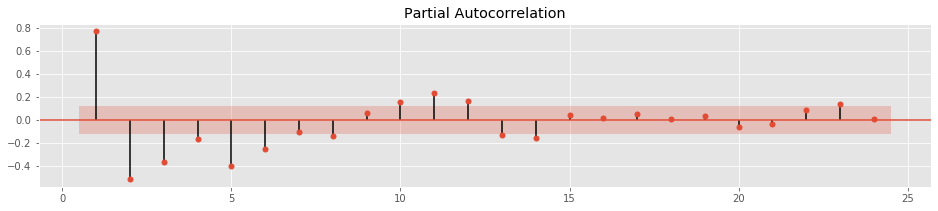

In [346]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff, ax=ax, lags=24, zero=False);

In [347]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

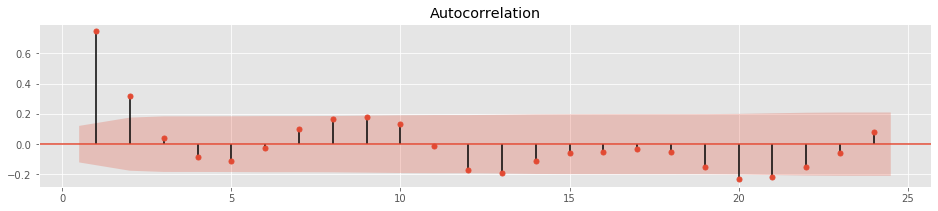

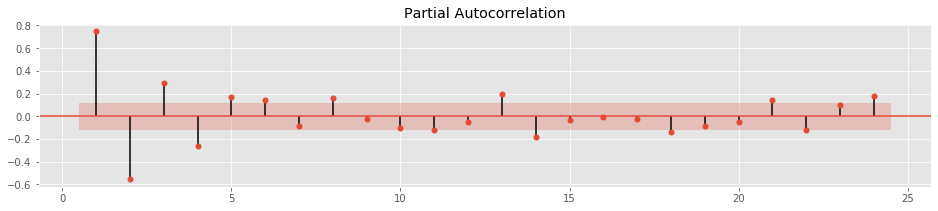

In [348]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff_11222, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff_11222, ax=ax, lags=24, zero=False);

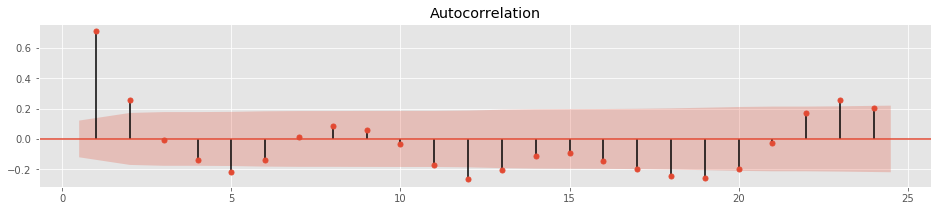

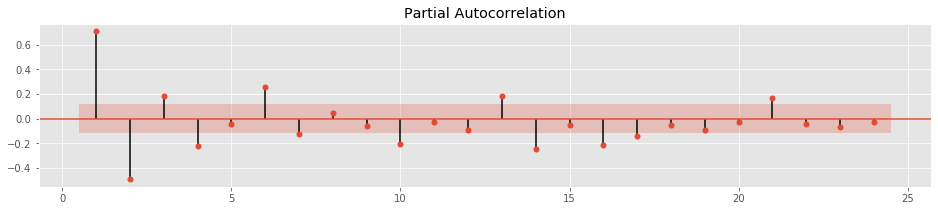

In [349]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff_11211, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff_11211, ax=ax, lags=24, zero=False);

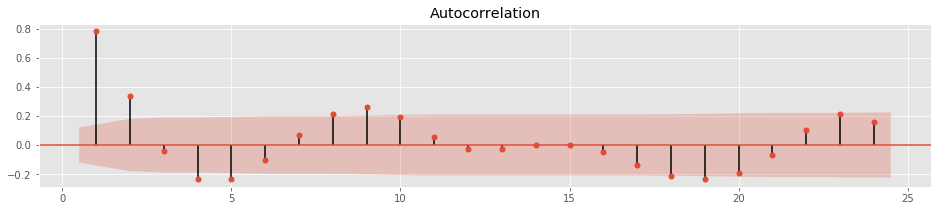

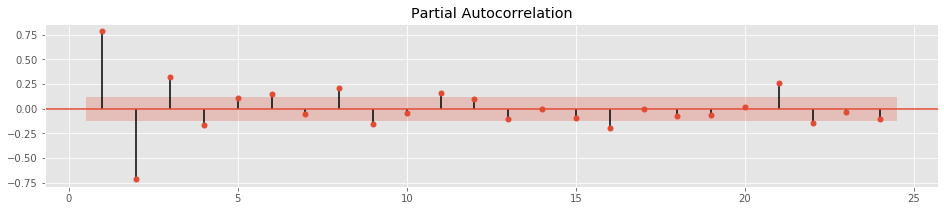

In [350]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff_11216, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff_11216, ax=ax, lags=24, zero=False);

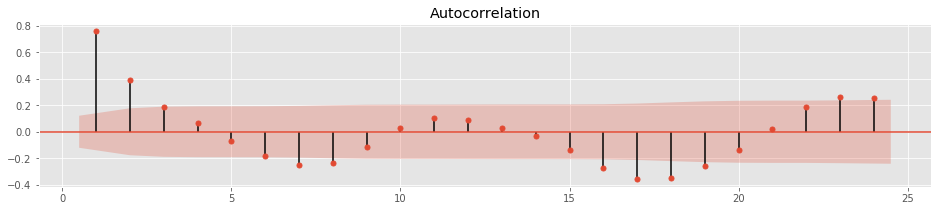

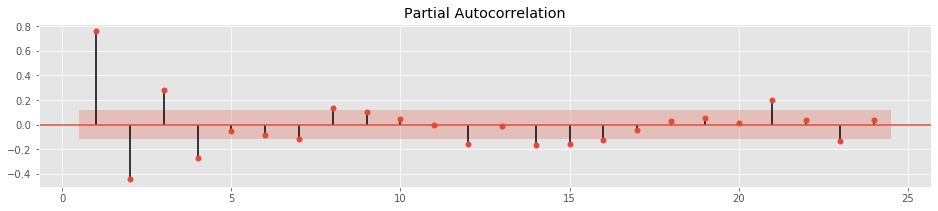

In [351]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff_11930, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff_11930, ax=ax, lags=24, zero=False);

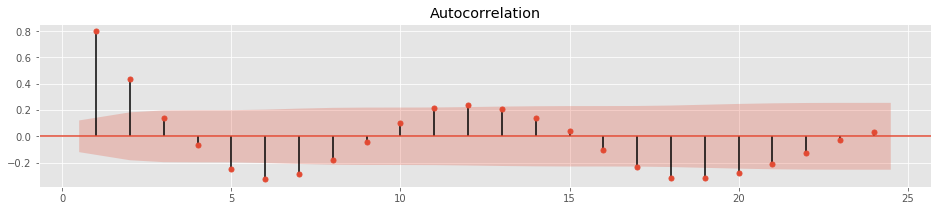

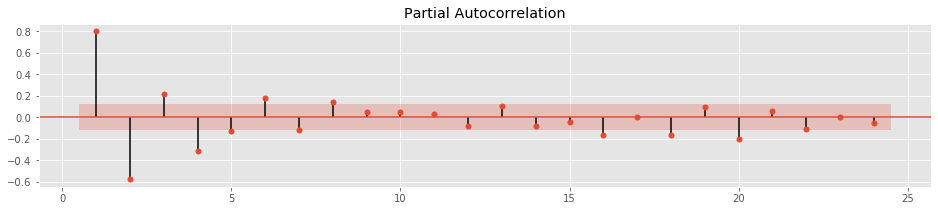

In [352]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff_11215, ax=ax, lags=24, zero=False);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff_11215, ax=ax, lags=24, zero=False);

In [353]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

In [354]:
auto_arima(data_diff_11222,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2686.302
Date:                Wed, 06 May 2020   AIC                           5382.604
Time:                        06:49:50   BIC                           5400.484
Sample:                             0   HQIC                          5389.789
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     65.7686   1280.960      0.051      0.959   -2444.867    2576.404
ar.L1          0.1383      0.076      1.829      0.067      -0.010       0.287
ma.L1          1.2989      0.059     22.078      0.000       1.184       1.414
ma.L2          0.6421      0.055     11.623      0.000       0.534       0.750
sigma2      4.275e+07      0.105   4.08e+08      0.000    4.27e+07    4.27e+07
===================================================================================
Ljung-Box (Q):                      112.62   Jarque-Bera (JB):               168.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              39.28   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.46e+23. Standard errors may be unstable.
"""

In [355]:
stepwise_fit_11222 = auto_arima(data_diff_11222, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit_11222.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=5730.581, BIC=5737.733, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=5518.071, BIC=5528.798, Time=0.031 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=5492.143, BIC=5502.871, Time=0.111 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5728.749, BIC=5732.325, Time=0.007 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=5410.982, BIC=5425.286, Time=0.056 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=5397.174, BIC=5415.054, Time=0.057 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=5426.926, BIC=5441.230, Time=0.029 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=5398.278, BIC=5419.733, Time=0.061 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=5383.463, BIC=5404.918, Time=0.095 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=5382.604, BIC=5400.484, Time=0.062 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2686.302
Date:                Wed, 06 May 2020   AIC                           5382.604
Time:                        06:49:51   BIC                           5400.484
Sample:                             0   HQIC                          5389.789
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     65.7686   1280.960      0.051      0.959   -2444.867    2576.404
ar.L1          0.1383      0.076      1.829      0.067      -0.010       0.287
ma.L1          1.2989      0.059     22.078      0.000       1.184       1.414
ma.L2          0.6421      0.055     11.623      0.000       0.534       0.750
sigma2      4.275e+07      0.105   4.08e+08      0.000    4.27e+07    4.27e+07
===================================================================================
Ljung-Box (Q):                      112.62   Jarque-Bera (JB):               168.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              39.28   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.46e+23. Standard errors may be unstable.
"""

In [356]:
auto_arima(data_diff_11211,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -2669.783
Date:                Wed, 06 May 2020   AIC                           5357.565
Time:                        06:49:55   BIC                           5389.749
Sample:                             0   HQIC                          5370.497
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    221.4042   1090.336      0.203      0.839   -1915.615    2358.423
ar.L1          0.9730      0.074     13.201      0.000       0.829       1.117
ar.L2         -0.5720      0.097     -5.891      0.000      -0.762      -0.382
ar.L3         -0.2855      0.071     -3.993      0.000      -0.426      -0.145
ma.L1          0.2209      0.056      3.945      0.000       0.111       0.331
ma.L2          0.0090      0.037      0.242      0.809      -0.064       0.082
ma.L3          0.4822      0.034     14.299      0.000       0.416       0.548
ma.L4          0.7654      0.050     15.203      0.000       0.667       0.864
sigma2      4.001e+07      0.008   4.72e+09      0.000       4e+07       4e+07
===================================================================================
Ljung-Box (Q):                       54.87   Jarque-Bera (JB):                79.90
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):              41.39   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+26. Standard errors may be unstable.
"""

In [357]:
stepwise_fit_11211 = auto_arima(data_diff_11211, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit_11211.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=5658.520, BIC=5665.672, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=5475.340, BIC=5486.068, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=5463.808, BIC=5474.536, Time=0.035 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5657.511, BIC=5661.087, Time=0.005 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=5407.300, BIC=5421.604, Time=0.029 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=5397.528, BIC=5415.408, Time=0.047 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=5406.715, BIC=5421.019, Time=0.032 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=5399.327, BIC=5420.783, Time=0.084 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=5376.255, BIC=5397.710, Time=0.153 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=5377.676, BIC=5395.556, Time=0.058 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -2678.652
Date:                Wed, 06 May 2020   AIC                           5369.305
Time:                        06:49:57   BIC                           5390.760
Sample:                             0   HQIC                          5377.926
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     59.5514     21.866      2.724      0.006      16.696     102.407
ar.L1          0.8933      0.036     24.573      0.000       0.822       0.965
ma.L1          0.3201      0.059      5.425      0.000       0.204       0.436
ma.L2         -0.6165      0.071     -8.624      0.000      -0.757      -0.476
ma.L3         -0.6934      0.055    -12.532      0.000      -0.802      -0.585
sigma2      4.405e+07   6.47e-05   6.81e+11      0.000    4.41e+07    4.41e+07
===================================================================================
Ljung-Box (Q):                       69.63   Jarque-Bera (JB):               131.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              41.63   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+28. Standard errors may be unstable.
"""

In [358]:
auto_arima(data_diff_11216,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -2577.548
Date:                Wed, 06 May 2020   AIC                           5171.097
Time:                        06:49:59   BIC                           5199.704
Sample:                             0   HQIC                          5182.592
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.8545    887.848      0.088      0.930   -1662.295    1818.004
ar.L1          0.3622      0.103      3.508      0.000       0.160       0.565
ar.L2          0.0600      0.148      0.405      0.685      -0.230       0.350
ar.L3         -0.0624      0.124     -0.502      0.616      -0.306       0.181
ar.L4         -0.1881      0.080     -2.340      0.019      -0.346      -0.031
ma.L1          1.2676      0.095     13.294      0.000       1.081       1.454
ma.L2          0.6584      0.071      9.338      0.000       0.520       0.797
sigma2      1.834e+07      0.048   3.83e+08      0.000    1.83e+07    1.83e+07
===================================================================================
Ljung-Box (Q):                       74.40   Jarque-Bera (JB):               442.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              53.34   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+25. Standard errors may be unstable.
"""

In [359]:
stepwise_fit_11216 = auto_arima(data_diff_11216, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit_11216.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=5631.865, BIC=5639.017, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=5384.552, BIC=5395.280, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=5372.819, BIC=5383.547, Time=0.082 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5630.471, BIC=5634.047, Time=0.006 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=5240.910, BIC=5255.213, Time=0.066 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=5177.610, BIC=5195.490, Time=0.056 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=5204.683, BIC=5218.987, Time=0.031 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=5178.554, BIC=5200.010, Time=0.107 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=5176.722, BIC=5198.177, Time=0.111 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=5185.441, BIC=5203.321, Time=0.045 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -2577.548
Date:                Wed, 06 May 2020   AIC                           5171.097
Time:                        06:50:02   BIC                           5199.704
Sample:                             0   HQIC                          5182.592
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.8545    887.848      0.088      0.930   -1662.295    1818.004
ar.L1          0.3622      0.103      3.508      0.000       0.160       0.565
ar.L2          0.0600      0.148      0.405      0.685      -0.230       0.350
ar.L3         -0.0624      0.124     -0.502      0.616      -0.306       0.181
ar.L4         -0.1881      0.080     -2.340      0.019      -0.346      -0.031
ma.L1          1.2676      0.095     13.294      0.000       1.081       1.454
ma.L2          0.6584      0.071      9.338      0.000       0.520       0.797
sigma2      1.834e+07      0.048   3.83e+08      0.000    1.83e+07    1.83e+07
===================================================================================
Ljung-Box (Q):                       74.40   Jarque-Bera (JB):               442.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              53.34   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+25. Standard errors may be unstable.
"""

In [360]:
stepwise_fit_11930 = auto_arima(data_diff_11930, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit_11930.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=5972.434, BIC=5979.586, Time=0.021 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=5743.876, BIC=5754.604, Time=0.028 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=5739.924, BIC=5750.652, Time=0.035 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5971.136, BIC=5974.712, Time=0.005 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=5649.750, BIC=5664.054, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=5647.229, BIC=5665.109, Time=0.039 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=5681.820, BIC=5696.124, Time=0.024 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=5647.187, BIC=5668.643, Time=0.085 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=5659.910, BIC=5677.790, Time=0.043 seconds
Fit ARIMA(4,0,1)x(0,0,0,0) [intercept=True]; AIC=5640.441, BIC=5665.473, Time=0.178 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -2813.464
Date:                Wed, 06 May 2020   AIC                           5638.929
Time:                        06:50:02   BIC                           5660.385
Sample:                             0   HQIC                          5647.551
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    254.5142    682.137      0.373      0.709   -1082.449    1591.477
ar.L1          1.3481      0.038     35.723      0.000       1.274       1.422
ar.L2         -1.0288      0.068    -15.145      0.000      -1.162      -0.896
ar.L3          0.6615      0.075      8.797      0.000       0.514       0.809
ar.L4         -0.2906      0.044     -6.673      0.000      -0.376      -0.205
sigma2      1.065e+08      0.019   5.74e+09      0.000    1.06e+08    1.06e+08
===================================================================================
Ljung-Box (Q):                       51.80   Jarque-Bera (JB):               683.05
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              19.85   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+24. Standard errors may be unstable.
"""

In [361]:
auto_arima(data_diff_11930,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2816.534
Date:                Wed, 06 May 2020   AIC                           5643.069
Time:                        06:50:03   BIC                           5660.948
Sample:                             0   HQIC                          5650.253
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    140.3316   1915.145      0.073      0.942   -3613.284    3893.948
ar.L1          0.2888      0.077      3.729      0.000       0.137       0.441
ma.L1          1.0895      0.076     14.245      0.000       0.940       1.239
ma.L2          0.4074      0.074      5.508      0.000       0.262       0.552
sigma2      1.164e+08      0.143   8.14e+08      0.000    1.16e+08    1.16e+08
===================================================================================
Ljung-Box (Q):                       71.13   Jarque-Bera (JB):               905.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.89   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.16e+24. Standard errors may be unstable.
"""

In [362]:
auto_arima(data_diff_11215,error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(5, 0, 2)   Log Likelihood               -2752.633
Date:                Wed, 06 May 2020   AIC                           5523.266
Time:                        06:50:05   BIC                           5555.450
Sample:                             0   HQIC                          5536.199
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -55.7748   1228.769     -0.045      0.964   -2464.118    2352.568
ar.L1          0.5709      0.142      4.013      0.000       0.292       0.850
ar.L2         -0.0541      0.166     -0.326      0.745      -0.379       0.271
ar.L3         -0.0614      0.144     -0.428      0.669      -0.343       0.220
ar.L4          0.1683      0.103      1.635      0.102      -0.033       0.370
ar.L5         -0.3074      0.064     -4.810      0.000      -0.433      -0.182
ma.L1          0.8645      0.151      5.721      0.000       0.568       1.161
ma.L2          0.2748      0.118      2.337      0.019       0.044       0.505
sigma2      6.913e+07      0.148   4.67e+08      0.000    6.91e+07    6.91e+07
===================================================================================
Ljung-Box (Q):                       49.37   Jarque-Bera (JB):              1075.94
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):              14.19   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+23. Standard errors may be unstable.
"""

In [363]:
stepwise_fit_11215 = auto_arima(data_diff_11215, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit_11215.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=5930.692, BIC=5937.844, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=5661.369, BIC=5672.097, Time=0.031 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=5699.821, BIC=5710.549, Time=0.049 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5928.717, BIC=5932.292, Time=0.008 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=5562.098, BIC=5576.401, Time=0.035 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=5553.762, BIC=5571.642, Time=0.052 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercept=True]; AIC=5532.470, BIC=5553.926, Time=0.067 seconds
Fit ARIMA(5,0,0)x(0,0,0,0) [intercept=True]; AIC=5530.010, BIC=5555.042, Time=0.081 seconds
Fit ARIMA(6,0,0)x(0,0,0,0) [intercept=True]; AIC=5525.435, BIC=5554.043, Time=0.084 seconds
Fit ARIMA(6,0,1)x(0,0,0,0) [intercept=True]; AIC=5524.037, BIC=5556.221, Time=0.148 seconds
Fit ARIMA(5,0,1)x(0,0,0,0) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(6, 0, 2)   Log Likelihood               -2745.911
Date:                Wed, 06 May 2020   AIC                           5511.822
Time:                        06:50:09   BIC                           5547.581
Sample:                             0   HQIC                          5526.191
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -55.7751   2184.020     -0.026      0.980   -4336.376    4224.826
ar.L1         -0.4044      0.060     -6.709      0.000      -0.522      -0.286
ar.L2          0.7074      0.060     11.859      0.000       0.590       0.824
ar.L3         -0.1962      0.074     -2.638      0.008      -0.342      -0.050
ar.L4         -0.0134      0.082     -0.162      0.871      -0.175       0.148
ar.L5          0.0415      0.058      0.720      0.471      -0.072       0.155
ar.L6         -0.4100      0.054     -7.560      0.000      -0.516      -0.304
ma.L1          1.8670      0.042     44.326      0.000       1.784       1.950
ma.L2          0.8951      0.041     21.928      0.000       0.815       0.975
sigma2      6.913e+07      0.552   1.25e+08      0.000    6.91e+07    6.91e+07
===================================================================================
Ljung-Box (Q):                       35.56   Jarque-Bera (JB):              1297.54
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):              12.78   Skew:                            -1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.51e+24. Standard errors may be unstable.
"""

In [364]:
df['res_price'] = res_ar7.resid

NameError: name 'res_ar7' is not defined

In [ ]:
df.res_price.mean()

In [ ]:
df.res_price.var()

In [ ]:
pp = df.res_price.dropna()

In [ ]:
adftest(pp)

In [365]:
import statsmodels.graphics.tsaplots as sgt

In [366]:
sgt.plot_acf(pp, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

NameError: name 'pp' is not defined

In [367]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

## Forecasting Zip 11222

In [379]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff_11222, 
                                        order=(1, 0, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1381      0.075      1.848      0.065      -0.008       0.284
ma.L1          1.3050      0.058     22.615      0.000       1.192       1.418
ma.L2          0.6486      0.055     11.880      0.000       0.542       0.756
sigma2      4.275e+07   6.15e-10   6.95e+16      0.000    4.28e+07    4.28e+07


In [381]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

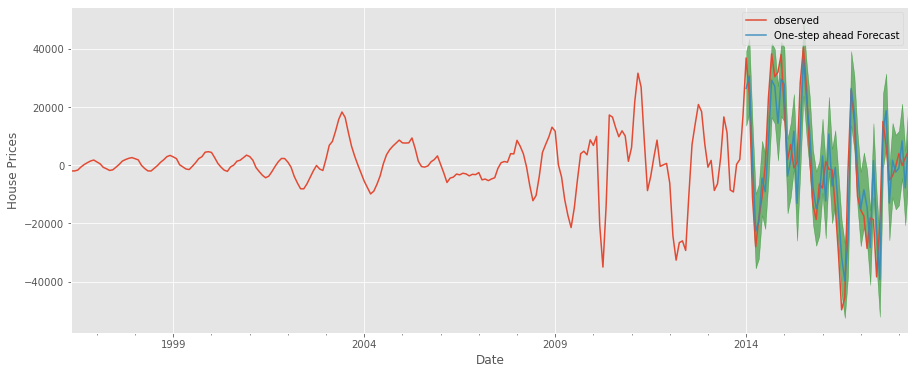

In [387]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_diff_11222.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
plt.legend()

plt.show()

In [388]:
# Get the real and predicted values
price_forecasted = pred.predicted_mean
price_truth = data_diff_11222['2014-01-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 114118211.23


In [390]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

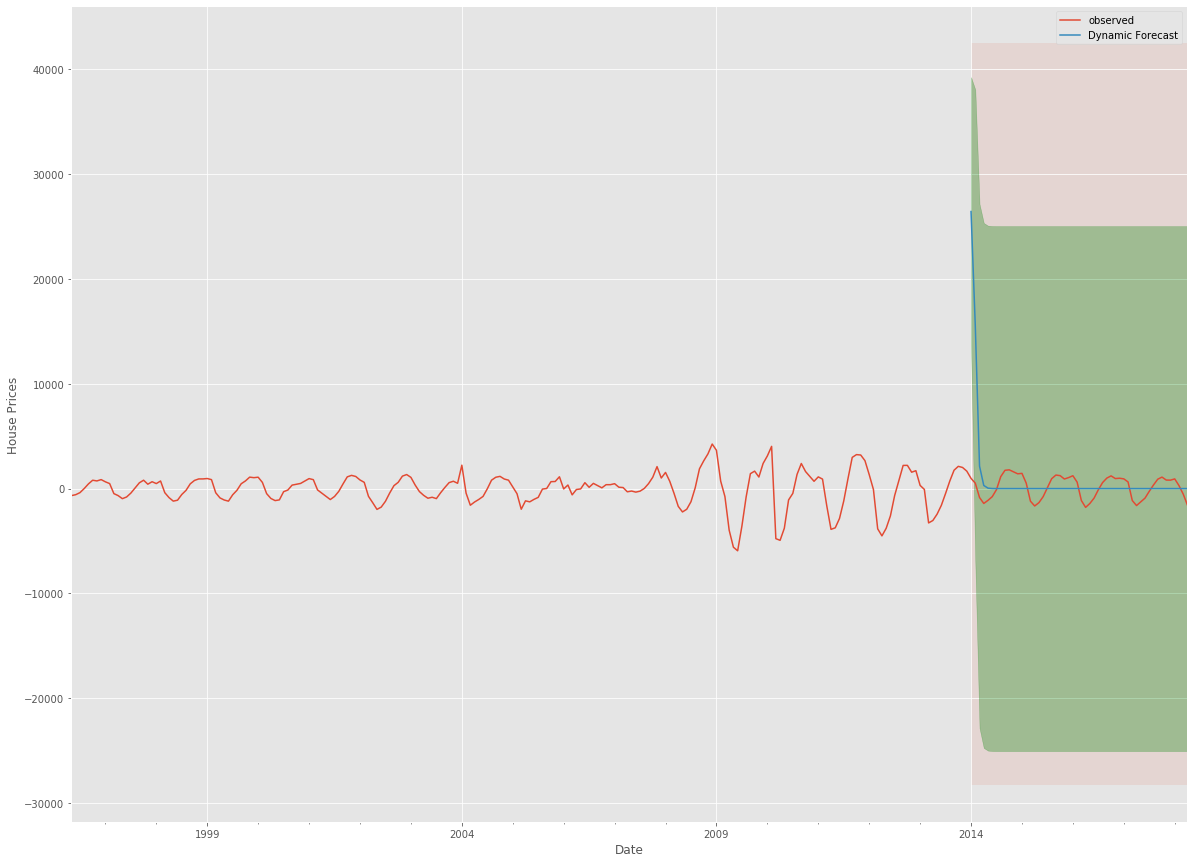

In [391]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

In [392]:
price_dy_forecasted = pred_dynamic.predicted_mean
price_dy_truth = data_diff_11222['2014-01-01':]

# Compute the mean square error
mse_dy = ((price_dy_forecasted - price_dy_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dy, 2)))

The Mean Squared Error of our forecasts is 425975088.26


## Forecasting zip 11211

In [367]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

In [393]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff_11211, 
                                        order=(3, 0, 4), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9685      0.073     13.179      0.000       0.824       1.113
ar.L2         -0.5582      0.095     -5.860      0.000      -0.745      -0.372
ar.L3         -0.2949      0.071     -4.173      0.000      -0.433      -0.156
ma.L1          0.2187      0.056      3.919      0.000       0.109       0.328
ma.L2          0.0123      0.038      0.319      0.750      -0.063       0.088
ma.L3          0.4969      0.044     11.167      0.000       0.410       0.584
ma.L4          0.7831      0.048     16.202      0.000       0.688       0.878
sigma2      4.006e+07   5.69e-10   7.04e+16      0.000    4.01e+07    4.01e+07


In [394]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

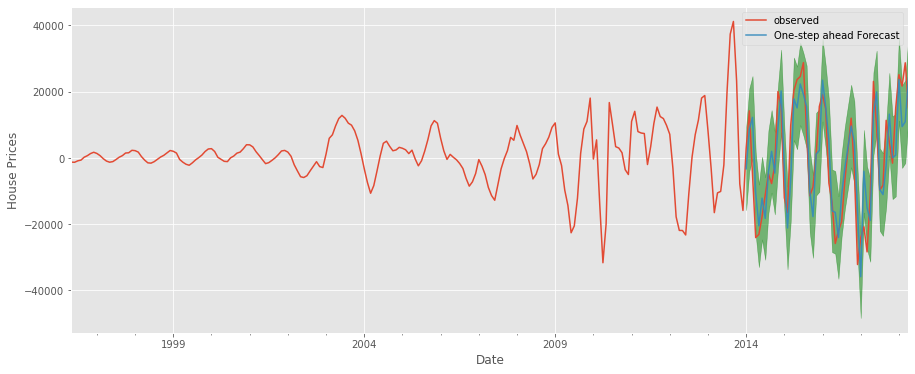

In [395]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_diff_11211.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
plt.legend()

plt.show()

In [396]:
# Get the real and predicted values
price_forecasted = pred.predicted_mean
price_truth = data_diff_11211['2014-01-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 83152161.14


In [397]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

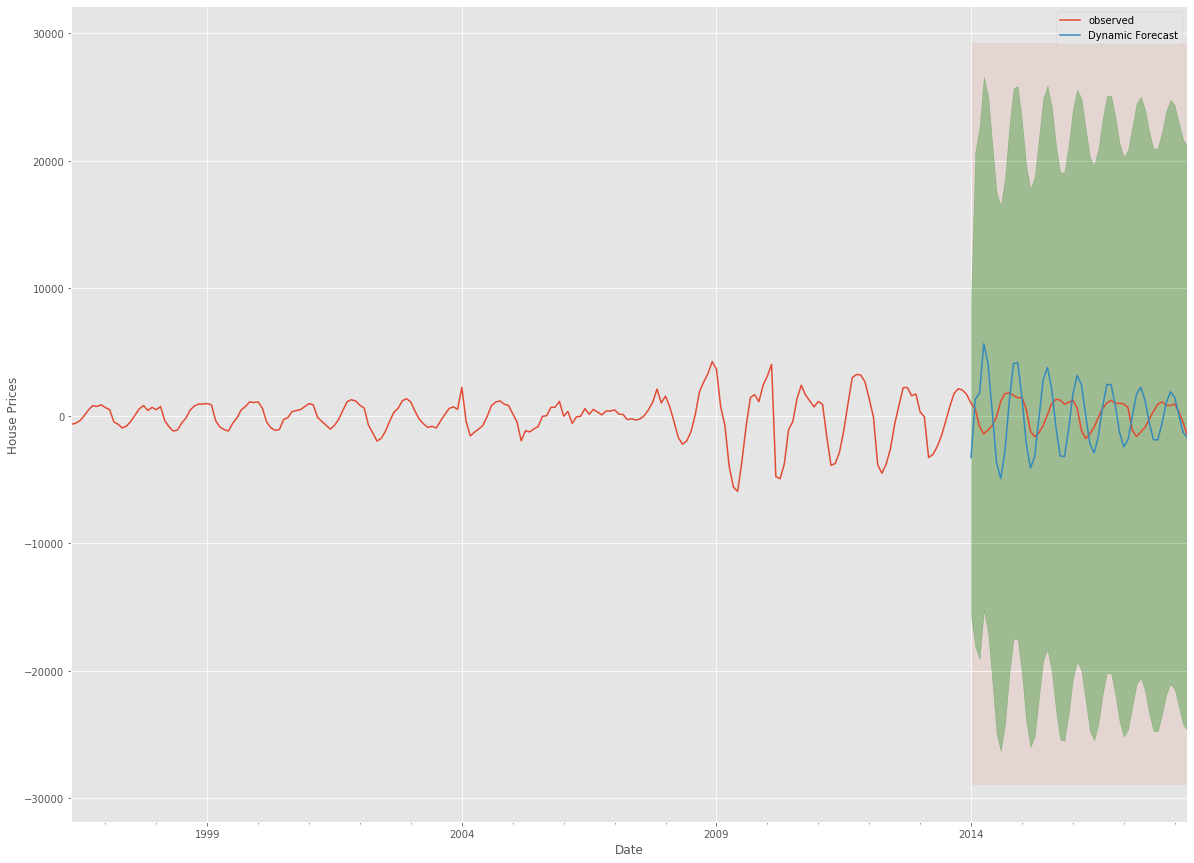

In [398]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

In [399]:
price_dy_forecasted = pred_dynamic.predicted_mean
price_dy_truth = data_diff_11211['2014-01-01':]

# Compute the mean square error
mse_dy = ((price_dy_forecasted - price_dy_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dy, 2)))

The Mean Squared Error of our forecasts is 270014680.3


##  Forecasting 11216

In [367]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

In [400]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff_11216, 
                                        order=(4, 0, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3340      0.161      2.070      0.038       0.018       0.650
ar.L2          0.4836      0.087      5.571      0.000       0.313       0.654
ar.L3         -0.6361      0.075     -8.495      0.000      -0.783      -0.489
ar.L4          0.1337      0.106      1.265      0.206      -0.073       0.341
ma.L1          1.2987      0.142      9.133      0.000       1.020       1.577
ma.L2          0.2868      0.150      1.907      0.057      -0.008       0.582
sigma2      1.834e+07   1.04e-08   1.76e+15      0.000    1.83e+07    1.83e+07


In [401]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

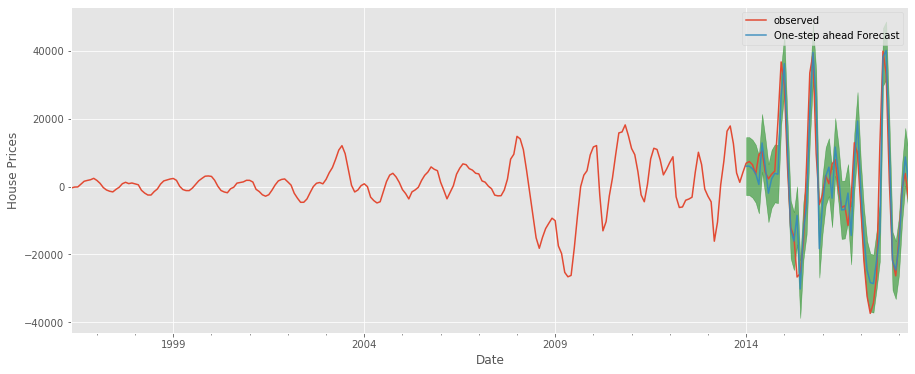

In [402]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_diff_11216.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
plt.legend()

plt.show()

In [403]:
# Get the real and predicted values
price_forecasted = pred.predicted_mean
price_truth = data_diff_11216['2014-01-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 61404176.76


In [404]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

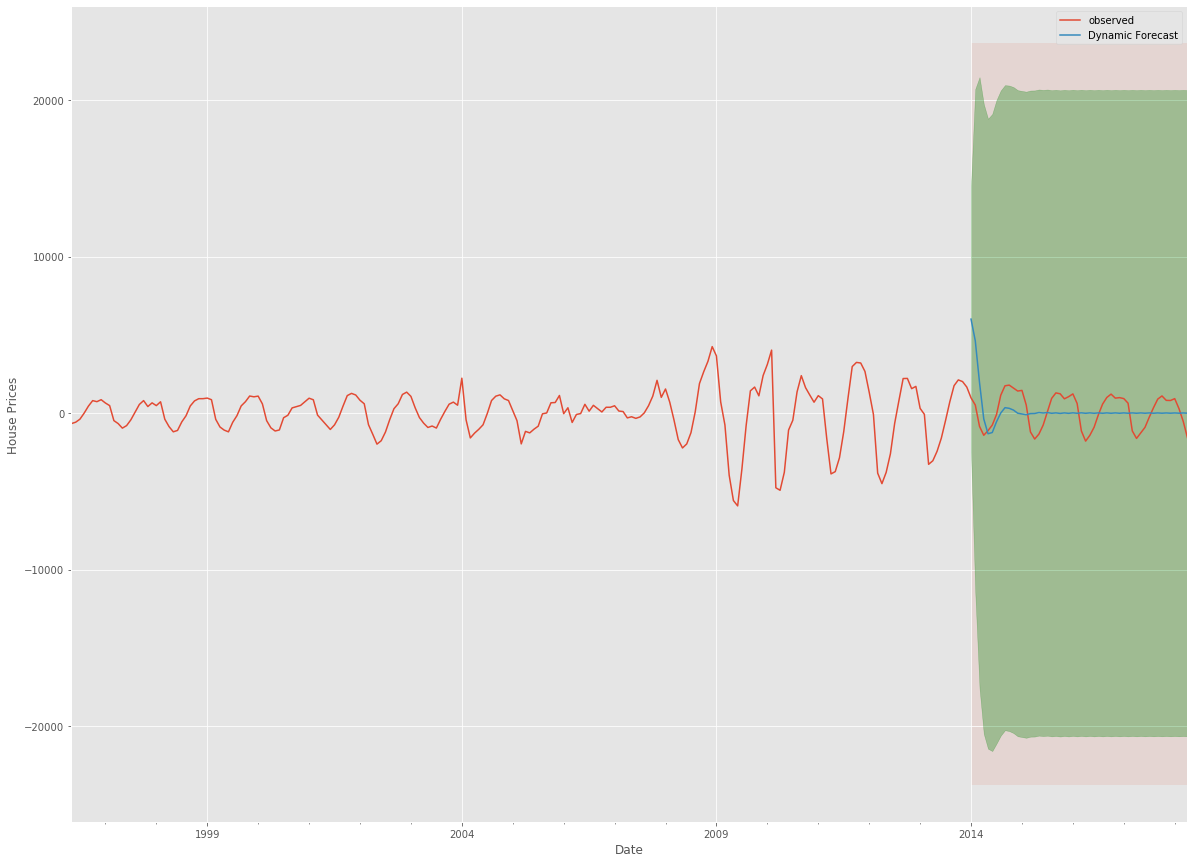

In [405]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

In [406]:
price_dy_forecasted = pred_dynamic.predicted_mean
price_dy_truth = data_diff_11216['2014-01-01':]

# Compute the mean square error
mse_dy = ((price_dy_forecasted - price_dy_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dy, 2)))

The Mean Squared Error of our forecasts is 335448109.25


## Forecasting zip 11930

In [367]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

In [407]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff_11930, 
                                        order=(4, 0, 0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3538      0.036     37.191      0.000       1.282       1.425
ar.L2         -1.0365      0.068    -15.348      0.000      -1.169      -0.904
ar.L3          0.6692      0.075      8.914      0.000       0.522       0.816
ar.L4         -0.2945      0.044     -6.741      0.000      -0.380      -0.209
sigma2      1.066e+08   2.15e-10   4.95e+17      0.000    1.07e+08    1.07e+08


In [408]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

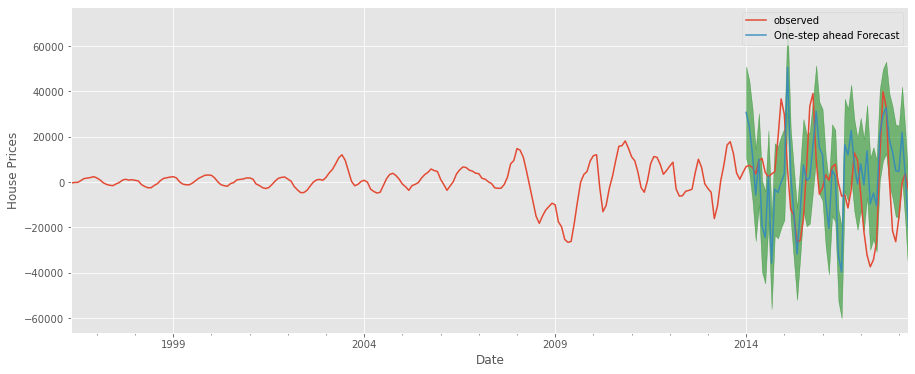

In [409]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_diff_11216.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
plt.legend()

plt.show()

In [410]:
# Get the real and predicted values
price_forecasted = pred.predicted_mean
price_truth = data_diff_11216['2014-01-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 493730306.99


In [411]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

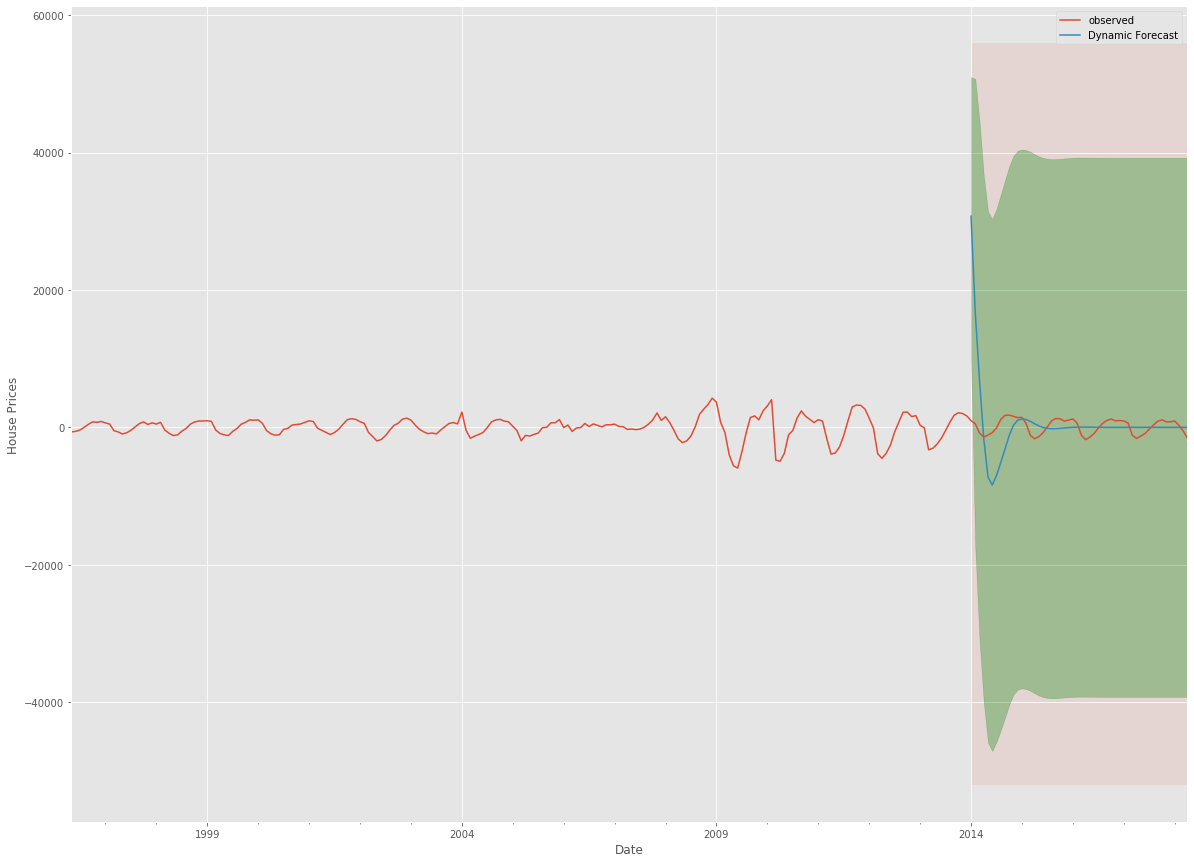

In [412]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

In [413]:
price_dy_forecasted = pred_dynamic.predicted_mean
price_dy_truth = data_diff_11216['2014-01-01':]

# Compute the mean square error
mse_dy = ((price_dy_forecasted - price_dy_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dy, 2)))

The Mean Squared Error of our forecasts is 357035363.45


## Forecasting zip 11215

In [367]:
zip_melted_df_merged.columns

Index(['infl_adj_value', 'melted_11222', 'melted_11211', 'melted_11216',
       'melted_11930', 'melted_11215'],
      dtype='object')

In [414]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_diff_11215, 
                                        order=(6, 0, 2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3743      0.061     -6.161      0.000      -0.493      -0.255
ar.L2          0.7155      0.058     12.386      0.000       0.602       0.829
ar.L3         -0.2174      0.076     -2.845      0.004      -0.367      -0.068
ar.L4         -0.0009      0.080     -0.011      0.991      -0.158       0.156
ar.L5          0.0393      0.058      0.680      0.496      -0.074       0.153
ar.L6         -0.4279      0.054     -7.869      0.000      -0.534      -0.321
ma.L1          1.8456      0.045     41.098      0.000       1.758       1.934
ma.L2          0.8729      0.043     20.219      0.000       0.788       0.958
sigma2      6.914e+07   9.95e-10   6.95e+16      0.000    6.91e+07    6.91e+07


In [415]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

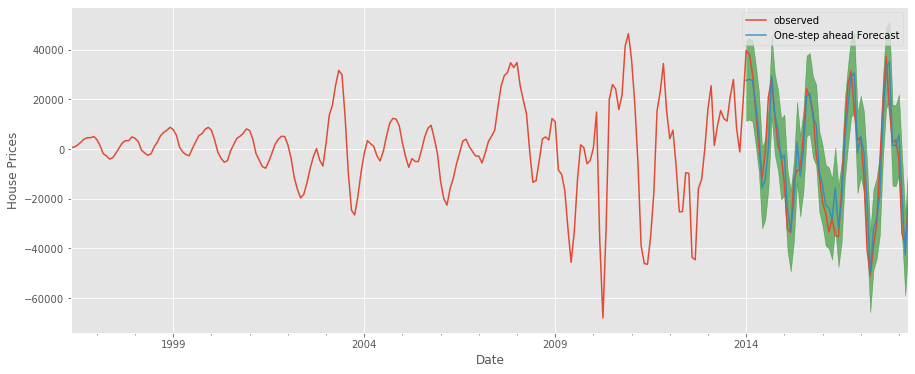

In [416]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_diff_11215.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')
plt.legend()

plt.show()

In [417]:
# Get the real and predicted values
price_forecasted = pred.predicted_mean
price_truth = data_diff_11215['2014-01-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 74005576.14


In [418]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

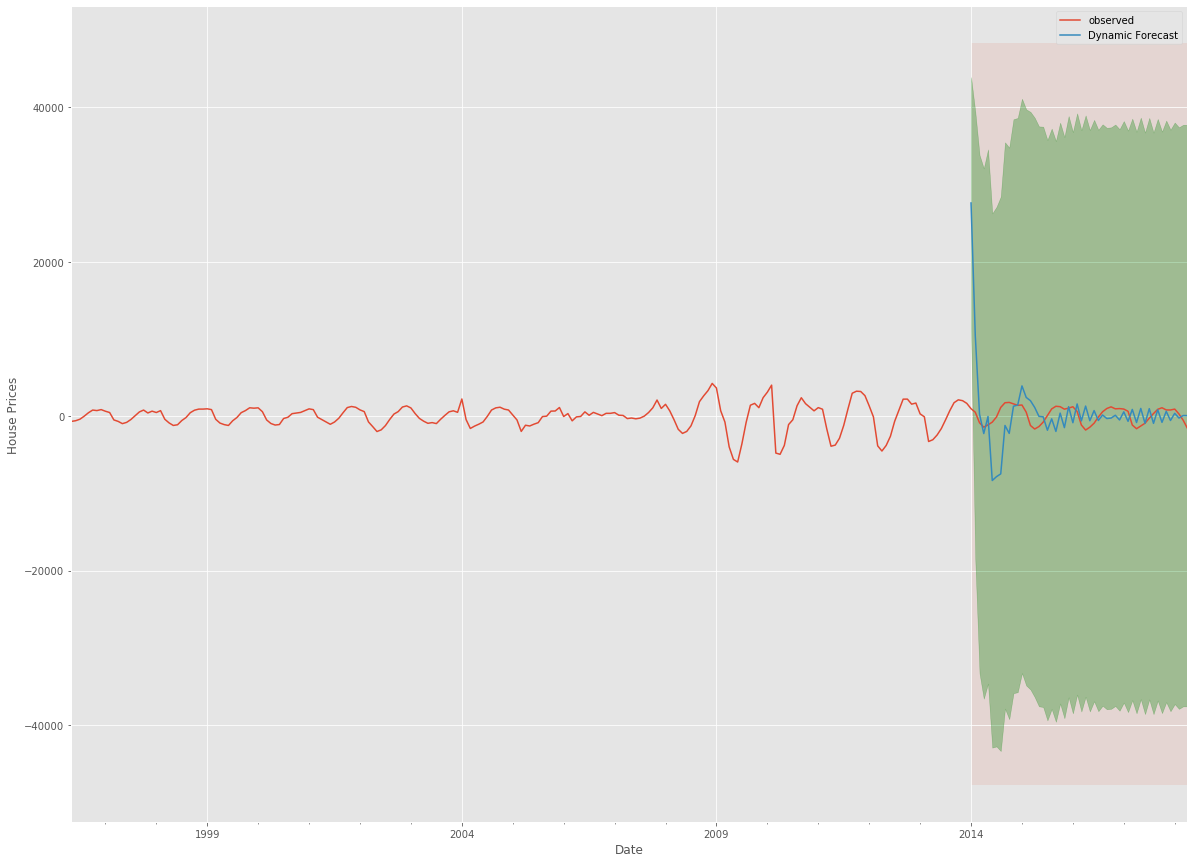

In [419]:
ax = data_diff.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

In [421]:
price_dy_forecasted = pred_dynamic.predicted_mean
price_dy_truth = data_diff_11215['2014-01-01':]

# Compute the mean square error
mse_dy = ((price_dy_forecasted - price_dy_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dy, 2)))

The Mean Squared Error of our forecasts is 551673475.81
